In [2]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  anti-His tag spots: All of the recombinant proteins that are used to coat the plates have hexa-His tags cloned into them, and the coat protein in these spots is anti-His. In this experiment, all of the recombinant antigens were spotted here on the anti-His coated spot, then serum was added so that the spot is representative of a polyclonal response. There was more cross-reactivity than expected and **this control will not be used in the future covid plates.**

# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# Read identity of wells and antigen spots in 2D arrays

In [3]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera/'
plateinfo_path=os.path.join(data_folder,'PlateInfo.csv')
antigenOD_path=os.path.join(data_folder,'20200327_analyzedPlate','ODs_2020_328_1030.xlsx')

In [4]:
plateinfo_dataframe=pd.read_csv(plateinfo_path)
pprint(plateinfo_dataframe)
plateInfo=plateinfo_dataframe.to_numpy()
pprint(plateInfo)

   Well     Sera ID              Type  Dilution
0    A1     Mouse 1        Diagnostic      1:50
1    A2     Mouse 1        Diagnostic      1:50
2    A3     Mouse 2        Diagnostic      1:50
3    A4     Mouse 2        Diagnostic      1:50
4    A5     Mouse 3        Diagnostic      1:50
..  ...         ...               ...       ...
91   H8  MAb-biotin  control/standard   0.41 nM
92   H9  MAb-biotin  control/standard  0.136 nM
93  H10  MAb-biotin  control/standard  0.045 nM
94  H11  MAb-biotin  control/standard  0.015 nM
95  H12         NaN               NaN       NaN

[96 rows x 4 columns]
array([['A1', 'Mouse 1', 'Diagnostic', '1:50'],
       ['A2', 'Mouse 1', 'Diagnostic', '1:50'],
       ['A3', 'Mouse 2', 'Diagnostic', '1:50'],
       ['A4', 'Mouse 2', 'Diagnostic', '1:50'],
       ['A5', 'Mouse 3', 'Diagnostic', '1:50'],
       ['A6', 'Mouse 3', 'Diagnostic', '1:50'],
       ['A7', 'Mouse 4', 'Diagnostic', '1:50'],
       ['A8', 'Mouse 4', 'Diagnostic', '1:50'],
       ['A9', 'Mo

In [7]:
converter = {col: str for col in range(0,7)}
antigens_dataframe=pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter)
antigens=antigens_dataframe.to_numpy()[:,1:] 
pprint(antigens)

array([['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
        'xkappa-biotin'],
       ['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
        'xmouse-IgG'],
       ['anti-HIS tag', '15731', '15742', '15750', '15878', '15946',
        '15960', 'Q411'],
       ['anti-HIS tag', '15731', '15742', '15750', '15878', '15946',
        '15960', 'Q411'],
       ['anti-HIS tag', '15974', '16061', 'FVM04', 'VIC122', 'Q206',
        'Q314', 'GFP-foldon'],
       ['xkappa-biotin', '15974', '16061', 'FVM04', 'VIC122', 'Q206',
        'Q314', 'xkappa-biotin']], dtype=object)


# Read ODs of all wells in a 4D array (Well row x Well column x Array row x Array column)

## Read data

In [8]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,8)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [9]:
# Read all wells into dictionary and into a 4D numpy array.
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        antigenOD_dataframe=pd.read_excel(antigenOD_path, sheet_name=well_key)
        antigenOD[r,c,:,:]=antigenOD_dataframe.to_numpy()[:,1:] # First column is simply the index. to_numpy returns 6x9 array.
        wellID[r,c] = well_key

## how to index the OD data.

#### direct indexing

In [11]:
pprint(antigenOD[0,0]) # Well A1

array([[1.48690358, 2.29510727, 1.88054858, 2.58605292, 1.28097541,
        2.65749052, 1.4895249 , 1.55835905],
       [1.46043415, 1.85433613, 2.27518306, 2.74934729, 1.43469453,
        2.05008816, 1.69365441, 3.02854479],
       [3.58943717, 1.60508459, 2.58859898, 1.26907949, 5.79775172,
        1.27786073, 1.82586891, 1.66100972],
       [3.3421515 , 1.81320625, 2.73909223, 1.27429019, 2.60367051,
        1.25637504, 2.31202412, 1.60264153],
       [3.43131823, 2.24281023, 3.27112586, 2.11036309, 2.43932369,
        2.12406351, 1.55815716, 4.61593211],
       [1.46372823, 2.1719292 , 3.20397848, 2.05375365, 2.36963313,
        2.01548414, 1.32053514, 1.4020999 ]])


In [12]:
pprint(antigenOD[0,3]) # well A4

array([[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
        1.08886344, 1.23414691, 1.61283121],
       [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
        1.081295  , 1.06818851, 3.55750328],
       [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
        1.03519571, 1.13637536, 1.10705243],
       [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
        1.04190418, 1.11740187, 1.08562124],
       [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
        1.0787549 , 1.05155942, 1.00879728],
       [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
        1.06769399, 1.05361099, 1.40577401]])


#### logical indexing

In [13]:
pprint(antigenOD[wellID == 'A4'])

array([[[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
         1.08886344, 1.23414691, 1.61283121],
        [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
         1.081295  , 1.06818851, 3.55750328],
        [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
         1.03519571, 1.13637536, 1.10705243],
        [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
         1.04190418, 1.11740187, 1.08562124],
        [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
         1.0787549 , 1.05155942, 1.00879728],
        [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
         1.06769399, 1.05361099, 1.40577401]]])


In [14]:
pprint(antigenOD[wellID == 'A1'])

array([[[1.48690358, 2.29510727, 1.88054858, 2.58605292, 1.28097541,
         2.65749052, 1.4895249 , 1.55835905],
        [1.46043415, 1.85433613, 2.27518306, 2.74934729, 1.43469453,
         2.05008816, 1.69365441, 3.02854479],
        [3.58943717, 1.60508459, 2.58859898, 1.26907949, 5.79775172,
         1.27786073, 1.82586891, 1.66100972],
        [3.3421515 , 1.81320625, 2.73909223, 1.27429019, 2.60367051,
         1.25637504, 2.31202412, 1.60264153],
        [3.43131823, 2.24281023, 3.27112586, 2.11036309, 2.43932369,
         2.12406351, 1.55815716, 4.61593211],
        [1.46372823, 2.1719292 , 3.20397848, 2.05375365, 2.36963313,
         2.01548414, 1.32053514, 1.4020999 ]]])


# Plot standard curve.

In [20]:
# Prepare arrays for logical indexing.
# Logical indexing works only for numpy array only not the standard python lists.

wellIdx = np.array([row+str(col) for row in ['A','B','C','D','E','F','G','H'] for col in range(1,13)])
wellmetaIdx=np.array(['Well','SeraID','Type','Concentration'])
antigenIdx = antigens.flatten()

# Transform antigenODs to wellxspot structure.
ODwellbyantigen=antigenOD.reshape(len(wellIdx),len(antigenIdx))
pprint(wellIdx)
pprint(antigenIdx)

array(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10',
       'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       'D8', 'D9', 'D10', 'D11', 'D12', 'E1', 'E2', 'E3', 'E4', 'E5',
       'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3',
       'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1',
       'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11',
       'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10',
       'H11', 'H12'], dtype='<U3')
array(['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
       'xkappa-biotin', 'xkappa-biotin', '114', '100', 'KZ52', 'c13C6',
       'c2G4', 'c4G7', 'xmouse-IgG', 'anti-HIS tag', '15731', '15742',
       '15750', '15878', '15946', '15960', 'Q411', 'anti-HIS tag',
       '15731', '15742', '15750', '

## Find concentrations in control wells

In [42]:
pprint(plateInfo)

array([['A1', 'Mouse 1', 'Diagnostic', '1:50'],
       ['A2', 'Mouse 1', 'Diagnostic', '1:50'],
       ['A3', 'Mouse 2', 'Diagnostic', '1:50'],
       ['A4', 'Mouse 2', 'Diagnostic', '1:50'],
       ['A5', 'Mouse 3', 'Diagnostic', '1:50'],
       ['A6', 'Mouse 3', 'Diagnostic', '1:50'],
       ['A7', 'Mouse 4', 'Diagnostic', '1:50'],
       ['A8', 'Mouse 4', 'Diagnostic', '1:50'],
       ['A9', 'Mouse 5', 'Diagnostic', '1:50'],
       ['A10', 'Mouse 5', 'Diagnostic', '1:50'],
       ['A11', 'Mouse 6', 'Diagnostic', '1:50'],
       ['A12', 'Mouse 6', 'Diagnostic', '1:50'],
       ['B1', 'Mouse 1', 'Diagnostic', '1:250'],
       ['B2', 'Mouse 1', 'Diagnostic', '1:250'],
       ['B3', 'Mouse 2', 'Diagnostic', '1:250'],
       ['B4', 'Mouse 2', 'Diagnostic', '1:250'],
       ['B5', 'Mouse 3', 'Diagnostic', '1:250'],
       ['B6', 'Mouse 3', 'Diagnostic', '1:250'],
       ['B7', 'Mouse 4', 'Diagnostic', '1:250'],
       ['B8', 'Mouse 4', 'Diagnostic', '1:250'],
       ['B9', 'Mouse 5', 'Dia

In [44]:
allWells = plateInfo[:,0]

In [143]:
controlWells=np.array(['H'+str(col) for col in range(2,12)])

controlConcentrations= np.concatenate([plateInfo[allWells == well,wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array(['300 nM', '100 nM', '33.3 nM', '11.1 nM', '3.7 nM', '1.23 nM',
       '0.41 nM', '0.136 nM', '0.045 nM', '0.015 nM'], dtype=object)


In [46]:
for well in controlWells:
    print(well)

H2
H3
H4
H5
H6
H7
H8
H9
H10
H11


In [48]:
concentrations=np.concatenate([np.fromstring(strconc, dtype=np.float32, sep=' ') for strconc in controlConcentrations])

<ipython-input-48-79577296ff9c>:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  concentrations=np.concatenate([np.fromstring(strconc, dtype=np.float32, sep=' ') for strconc in controlConcentrations])


In [49]:
pprint(concentrations)

array([3.00e+02, 1.00e+02, 3.33e+01, 1.11e+01, 3.70e+00, 1.23e+00,
       4.10e-01, 1.36e-01, 4.50e-02, 1.50e-02], dtype=float32)


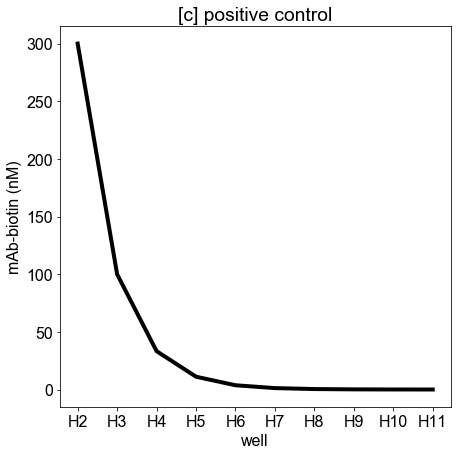

In [50]:
plt.figure(figsize=(7,7))
plt.plot(concentrations, lw=4, c='k')
plt.xticks(ticks=np.arange(len(concentrations)),labels=controlWells)
plt.xlabel('well')
plt.ylabel('mAb-biotin (nM)')
plt.title('[c] positive control');

## OD of xkappa-biotin should not change with concentration.

In [51]:
# Extract ODs across control wells and over all spots.
xkappaOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'xkappa-biotin'] for well in controlWells])
xkappaODMean=np.mean(xkappaOD, axis =1)

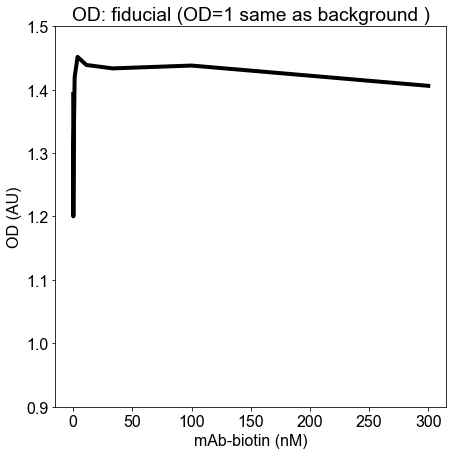

In [52]:
plt.figure(figsize=(7,7))
plt.plot(concentrations, xkappaODMean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: fiducial (OD=1 same as background )');

## OD of GFP-foldon (-ve control) should be lower than fiducial

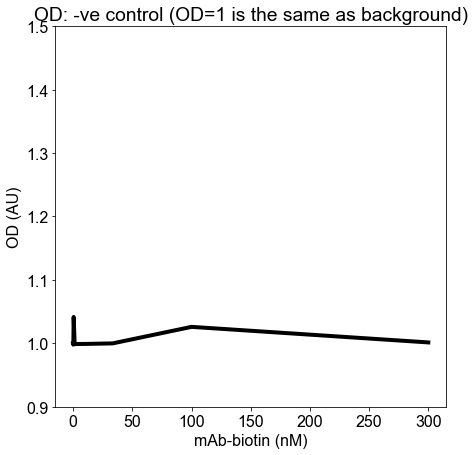

In [53]:
GFPfoldonOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'GFP-foldon'] for well in controlWells])
GFPfoldonODmean=np.mean(GFPfoldonOD, axis =1)
plt.figure(figsize=(7,7))
plt.plot(concentrations, GFPfoldonODmean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: -ve control (OD=1 is the same as background)');

## OD of  (+ve control) should be higher than fiducial

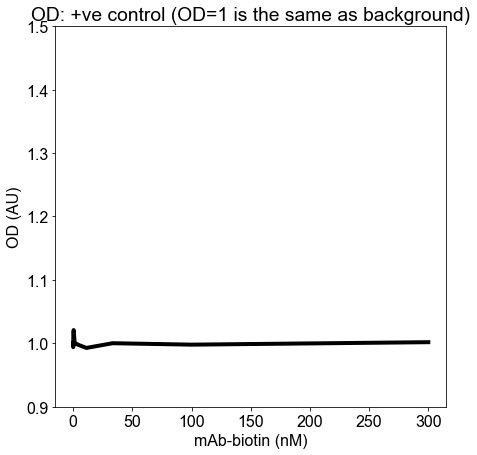

In [54]:
xmouseIgGOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'xmouse-IgG'] for well in controlWells])
xmouseIgGODmean=np.mean(xmouseIgGOD, axis =1)
plt.figure(figsize=(7,7))
plt.plot(concentrations, xmouseIgGODmean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: +ve control (OD=1 is the same as background)');

## +ve control didn't seem to work, let's look at images. 
spot 2-8 in raw data is +ve control (xmouse-IgG), and spot 5-8 is -ve control (GFP foldon). Plots match the data

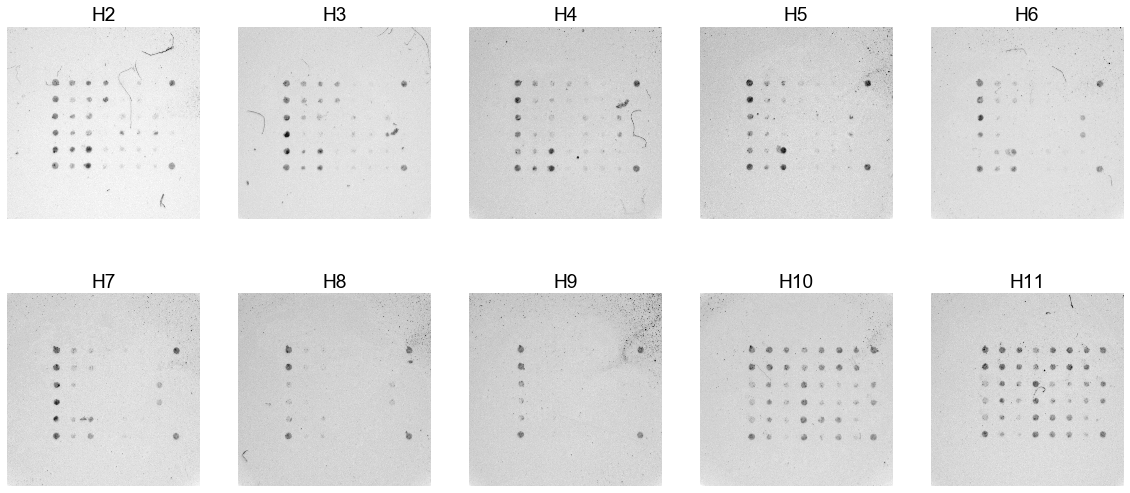

In [55]:
fig, ax = plt.subplots(2,int(len(controlWells)/2),figsize=(20,9))
ax=ax.flatten()
for n in range(len(controlWells)):
    wellImg=io.imread(os.path.join(data_folder,'20200327_analyzedPlate',controlWells[n]+'_crop.png'))
    ax[n].imshow(wellImg,cmap='gray')
    ax[n].set_title(controlWells[n])             
    ax[n].axis('off')

## Extract and mean ODs for each antigen for each mouse.

Select a dilution that has high OD values in the positive control and
low negative OD values in the negative control. Based on visual
inspection of the images, I would choose row C of the plate, because
there seems to be decent dynamic range across most antigens by eye. With
successful standard curve, we could select whichever row has OD values
within the middle 60% of the OD values reported on the standard curve.

For each well, there are technical replicates for each antigen. Mean the
OD values of C1+C2, C3+C4, C5+C6, C8+C8, C9+C10, C11+C12 for each
antigen. These are biological replicates from 6 mice.

Extract ODs across C1,C2 wells and over antigen 114 spots. Do this for all mice 1-6, for all antigens. 

In [65]:
mouse1Wells=np.array(['C'+str(col) for col in range(1,3)])	# C1 and C2 wells
pprint(mouse1Wells)
OD114=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse1Wells]) # Extract ODs
OD114Mean=np.mean(OD114) # mean the 114 spot ODs for the 2 wells, this is outputs 2 means. Do I want that?
pprint(OD114)
pprint(OD114Mean) 

array(['C1', 'C2'], dtype='<U2')
array([[1.45386378, 1.54574571],
       [1.4626992 , 1.58615411]])
1.5121157022553944


In [57]:
pprint(ODwellbyantigen)

array([[1.48690358, 2.29510727, 1.88054858, ..., 2.01548414, 1.32053514,
        1.4020999 ],
       [1.50692973, 2.41614742, 2.03945548, ..., 2.0504722 , 1.34960218,
        1.37970885],
       [1.56320056, 1.19846211, 4.16765869, ..., 1.07023413, 1.04914805,
        1.38269309],
       ...,
       [1.36185653, 1.40515952, 1.31892479, ..., 1.21483076, 1.041379  ,
        1.31235502],
       [1.41354671, 1.39439183, 1.41857804, ..., 1.22375818, 1.04448527,
        1.33651583],
       [1.47166709, 1.46767573, 1.36877155, ..., 1.22484217, 1.04085489,
        1.36492366]])


In [58]:
ODwellbyantigen.shape

(96, 48)

In [60]:
plateInfo[:,1]

array(['Mouse 1', 'Mouse 1', 'Mouse 2', 'Mouse 2', 'Mouse 3', 'Mouse 3',
       'Mouse 4', 'Mouse 4', 'Mouse 5', 'Mouse 5', 'Mouse 6', 'Mouse 6',
       'Mouse 1', 'Mouse 1', 'Mouse 2', 'Mouse 2', 'Mouse 3', 'Mouse 3',
       'Mouse 4', 'Mouse 4', 'Mouse 5', 'Mouse 5', 'Mouse 6', 'Mouse 6',
       'Mouse 1', 'Mouse 1', 'Mouse 2', 'Mouse 2', 'Mouse 3', 'Mouse 3',
       'Mouse 4', 'Mouse 4', 'Mouse 5', 'Mouse 5', 'Mouse 6', 'Mouse 6',
       'Mouse 1', 'Mouse 1', 'Mouse 2', 'Mouse 2', 'Mouse 3', 'Mouse 3',
       'Mouse 4', 'Mouse 4', 'Mouse 5', 'Mouse 5', 'Mouse 6', 'Mouse 6',
       'Mouse 1', 'Mouse 1', 'Mouse 2', 'Mouse 2', 'Mouse 3', 'Mouse 3',
       'Mouse 4', 'Mouse 4', 'Mouse 5', 'Mouse 5', 'Mouse 6', 'Mouse 6',
       'Mouse 1', 'Mouse 1', 'Mouse 2', 'Mouse 2', 'Mouse 3', 'Mouse 3',
       'Mouse 4', 'Mouse 4', 'Mouse 5', 'Mouse 5', 'Mouse 6', 'Mouse 6',
       'Mouse 1', 'Mouse 1', 'Mouse 2', 'Mouse 2', 'Mouse 3', 'Mouse 3',
       'Mouse 4', 'Mouse 4', 'Mouse 5', 'Mouse 5', 

In [61]:
plateInfo[:,1] == 'Mouse 1'

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [64]:
ODwellbyantigen[plateInfo[:,1]=='Mouse 1'].shape

(14, 48)

In [79]:
PlateID_array = np.array(['C' in plateInfo[i,0] for i in range(len(plateInfo))])

In [80]:
pprint(PlateID_array)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])


In [81]:
np.logical_and(PlateID_array, plateInfo[:,1] == 'Mouse 1')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [82]:
plateInfo[np.logical_and(PlateID_array, plateInfo[:,1] == 'Mouse 1')]

array([['C1', 'Mouse 1', 'Diagnostic', '1:1250'],
       ['C2', 'Mouse 1', 'Diagnostic', '1:1250']], dtype=object)

In [83]:
mouseAndWellidx = np.logical_and(PlateID_array, plateInfo[:,1] == 'Mouse 1')

In [84]:
mouseAndWellidx

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [85]:
ODwellbyantigen[mouseAndWellidx,antigenIdx == '114']
pprint(ODwellbyantigen[mouseAndWellidx,antigenIdx == '114'])

array([1.45386378, 1.58615411])


In [86]:
pprint(antigenIdx == '114')

array([False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])


In [87]:
counter =0
for idx in range(len(mouseAndWellidx)):
    if mouseAndWellidx[idx] == True:
        if counter == 0:
            array = ODwellbyantigen[idx, antigenIdx=='114']
            counter +=1
        else:
            array = np.concatenate((array, ODwellbyantigen[idx, antigenIdx=='114']),axis=0)
        

In [88]:
array

array([1.45386378, 1.54574571, 1.4626992 , 1.58615411])

In [89]:
array.shape

(4,)

## Pull all ODs for spots 114 for all mice

In [312]:
mouseList = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4', 'Mouse 5', 'Mouse 6']
meanSingleAntigenForMouse = np.zeros(len(mouseList))

for mouseName_idx, mouseName in enumerate(mouseList):
    PlateID_array = np.array(['C' in plateInfo[i,0] for i in range(len(plateInfo))])
    mouseAndWellidx = np.logical_and(PlateID_array, plateInfo[:,1] == mouseName)
    counter =0
    for idx in range(len(mouseAndWellidx)):
        if mouseAndWellidx[idx] == True:
            if counter == 0:
                array = ODwellbyantigen[idx, antigenIdx=='114']
                counter +=1
            else:
                array = np.concatenate((array, ODwellbyantigen[idx, antigenIdx=='114']),axis=0)
                pprint(array)
           
    meanSingleAntigenForMouse[mouseName_idx] = np.mean(array)
pprint(meanSingleAntigenForMouse)
                
                


array([1.45386378, 1.54574571, 1.4626992 , 1.58615411])
array([1.42565596, 1.37252841, 1.3549812 , 1.39352406])
array([1.45737275, 1.45192754, 1.50224867, 1.45049116])
array([1.16792262, 1.19920099, 1.54740016, 1.5135769 ])
array([1.52520574, 1.52280734, 1.66170611, 1.54928673])
array([1.64994294, 1.68208177, 1.7017047 , 1.66435221])
array([1.5121157 , 1.38667241, 1.46551003, 1.35702517, 1.56475148,
       1.67452041])


In [310]:
pprint(meanSingleAntigenForMouse)

array([1.5121157 , 1.38667241, 1.46551003, 1.35702517, 1.56475148,
       1.67452041])


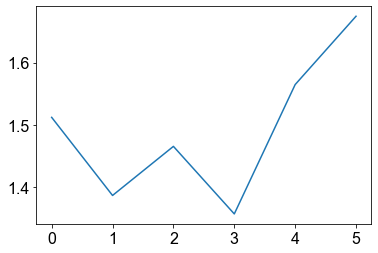

In [94]:
plt.plot(meanSingleAntigenForMouse)

## Fit a curve to the standards
First average the replicates for the standard spots in each well. 

In [307]:
concentrationList = ['300 nM', ' 100 nM', '33.3 nM', '11.1 nM', '3.7 nM', '1.23 nM', '0.41 nM', '0.136 nM', '0.045 nM', '0.015 nM']
listof16061WellMeans = np.zeros(len(concentrationList))

for concentrationName_idx, concentrationName in enumerate(concentrationList):
    PlateID_array = np.array(['H' in plateInfo[i,0] for i in range(len(plateInfo))])
    concentrationAndWellidx = np.logical_and(PlateID_array, plateInfo[:,3] == concentrationName)
    counter =0
    for idx in range(len(concentrationAndWellidx)):
        if concentrationAndWellidx[idx] == True:
            if counter == 0:
                array = ODwellbyantigen[idx, antigenIdx=='16061']
                counter +=1
            else:
                array = np.concatenate((array, ODwellbyantigen[idx, antigenIdx=='16061']),axis=0)
                
    listof16061WellMeans[concentrationName_idx] = np.mean(array)

In [308]:
pprint(listof16061WellMeans)

array([1.64565504, 1.64565504, 1.48771684, 1.46962538, 1.28698003,
       1.17924281, 1.17528948, 1.01690498, 1.03338037, 1.03259042])


In [293]:
flipWellMeans = np.flip(listof16061WellMeans) #flip for plotting increasing concentration based on OD
pprint(flipWellMeans)

array([1.03259042, 1.03338037, 1.01690498, 1.17528948, 1.17924281,
       1.28698003, 1.46962538, 1.48771684, 1.64565504, 1.64565504])


In [149]:
concentrationList

[300, 100, 22.2, 11.1, 3.7, 1.23, 0.41, 0.136, 0.045, 0.015]

In [258]:
concentrationList=[300,100,22.2,11.1,3.7,1.23,0.41,0.136,0.045,0.015]

In [259]:
concentrationListIncreasing=np.flip(concentrationList)

In [260]:
from scipy import optimize

def test_func(x, a, b, c):
    return a * np.exp(-b * x) + c

params, params_covariance = optimize.curve_fit(test_func, concentrationListIncreasing, flipWellMeans)

print(params)

[-0.54973597  0.11690551  1.61577432]


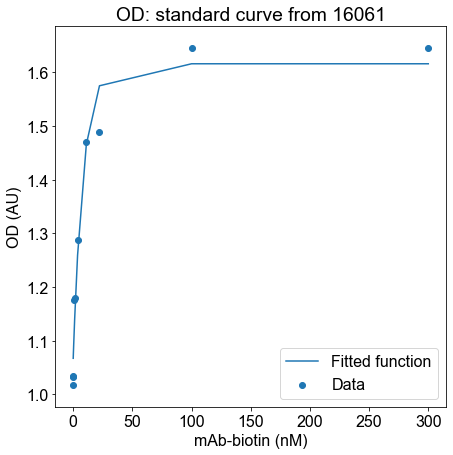

In [261]:
plt.figure(figsize=(7, 7))
plt.scatter(concentrationListIncreasing, flipWellMeans, label='Data')
plt.plot(concentrationListIncreasing, test_func(concentrationListIncreasing, params[0], params[1], params[2]),
         label='Fitted function')

plt.legend(loc='best')
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: standard curve from 16061');

plt.show()

#Still need to improve the curve fitting, but it is a start

## Use curve fit for finding unknown sample concentrations

In [287]:
concentrationOf16061Mice=test_func(meanSingleAntigenForMouse, params[0],params[1],params[2])
pprint(concentrationOf16061Mice)
correctedConcentrationOf16061Mice = [i * 125 for i in concentrationOf16061Mice]
print(correctedConcentrationOf16061Mice)

array([1.15603817, 1.15541339, 1.15607103, 1.15193246, 1.15336448,
       1.15561796])
[144.50477182511216, 144.42667436023933, 144.50887825239568, 143.99155731384133, 144.17056045240543, 144.4522444293779]


In [291]:
def SingleAntigenConcentration(meanSingleAntigenForMouse):
    for mean in meanSingleAntigenForMouse:
        SingleAntigenConcentration = test_func(mean, params[0], params[1], params[2])
        pprint(SingleAntigenConcentration)
SingleAntigenConcentration(meanSingleAntigenForMouse)
#Don't forget to add dilution multiplier here. Can't iterate as above because float.

1.1560381746008972
1.1554133948819147
1.1560710260191653
1.1519324585107307
1.1533644836192434
1.1556179554350232


## Iterate over every antigen
This is still very much in progress--Goal is to output an array with a mean concentration value for each mouse for each antigen. The following cells are still my chicken scratch.

In [194]:
pprint(antigenIdx)

array(['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
       'xkappa-biotin', 'xkappa-biotin', '114', '100', 'KZ52', 'c13C6',
       'c2G4', 'c4G7', 'xmouse-IgG', 'anti-HIS tag', '15731', '15742',
       '15750', '15878', '15946', '15960', 'Q411', 'anti-HIS tag',
       '15731', '15742', '15750', '15878', '15946', '15960', 'Q411',
       'anti-HIS tag', '15974', '16061', 'FVM04', 'VIC122', 'Q206',
       'Q314', 'GFP-foldon', 'xkappa-biotin', '15974', '16061', 'FVM04',
       'VIC122', 'Q206', 'Q314', 'xkappa-biotin'], dtype=object)


#Initialize dictionary of antigen name corresponding to list containing mean concentrations for 6 mice

In [317]:
antigenList = ['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7','xmouse-IgG','anti-HIS tag', '15731', '15742', '15750', '15878', '15946','15960', 'Q411', '15974', '16061', 'FVM04', 'VIC122', 'Q206','Q314', 'GFP-foldon']
concentrationResults = {i:[50,50,50,50,50,50] for i in antigenList}

pprint(concentrationResults)

{'100': [50, 50, 50, 50, 50, 50],
 '114': [50, 50, 50, 50, 50, 50],
 '15731': [50, 50, 50, 50, 50, 50],
 '15742': [50, 50, 50, 50, 50, 50],
 '15750': [50, 50, 50, 50, 50, 50],
 '15878': [50, 50, 50, 50, 50, 50],
 '15946': [50, 50, 50, 50, 50, 50],
 '15960': [50, 50, 50, 50, 50, 50],
 '15974': [50, 50, 50, 50, 50, 50],
 '16061': [50, 50, 50, 50, 50, 50],
 'FVM04': [50, 50, 50, 50, 50, 50],
 'GFP-foldon': [50, 50, 50, 50, 50, 50],
 'KZ52': [50, 50, 50, 50, 50, 50],
 'Q206': [50, 50, 50, 50, 50, 50],
 'Q314': [50, 50, 50, 50, 50, 50],
 'Q411': [50, 50, 50, 50, 50, 50],
 'VIC122': [50, 50, 50, 50, 50, 50],
 'anti-HIS tag': [50, 50, 50, 50, 50, 50],
 'c13C6': [50, 50, 50, 50, 50, 50],
 'c2G4': [50, 50, 50, 50, 50, 50],
 'c4G7': [50, 50, 50, 50, 50, 50],
 'xkappa-biotin': [50, 50, 50, 50, 50, 50],
 'xmouse-IgG': [50, 50, 50, 50, 50, 50]}


In [318]:
len(antigenList)

29

In [322]:
#Define a function that takes antigen name (str) as the argument

In [321]:
def findMeanODs(antigen):
    mouseList = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4', 'Mouse 5', 'Mouse 6']
    meanSingleAntigenForMouse = np.zeros(len(mouseList))

    for mouseName_idx, mouseName in enumerate(mouseList):
        PlateID_array = np.array(['C' in plateInfo[i,0] for i in range(len(plateInfo))])
        mouseAndWellidx = np.logical_and(PlateID_array, plateInfo[:,1] == mouseName)
        counter =0
        for idx in range(len(mouseAndWellidx)):
            if mouseAndWellidx[idx] == True:
                if counter == 0:
                    array = ODwellbyantigen[idx, antigenIdx==antigen]
                    counter +=1
                else:
                    array = np.concatenate((array, ODwellbyantigen[idx, antigenIdx==antigen]),axis=0)
                    pprint(array)
        meanSingleAntigenForMouse[mouseName_idx] = np.mean(array)
    pprint(meanSingleAntigenForMouse)

In [323]:
for antigen in concentrationResults:
    findMeanODs(antigen)
    concentrationResults.update({antigen:meanSingleAntigenForMouse})
pprint(concentrationResults)

array([1.5967797 , 1.59511597, 1.60671339, 1.71466466, 1.38157853,
       1.44164653, 1.48736801, 1.56529985, 1.50605912, 1.39792707])
array([1.473988  , 1.71933269, 1.55533473, 1.56317716, 1.43780321,
       1.46801839, 1.5761103 , 1.47791904, 1.49145637, 1.41384446])
array([1.46787027, 1.59124331, 1.56585622, 1.53481665, 1.42222563,
       1.55434303, 1.63507797, 1.57112889, 1.48922901, 1.46747446])
array([1.47055562, 1.51235291, 1.58673008, 1.43823709, 1.37374584,
       1.42551705, 1.48068722, 1.39983387, 1.50351912, 1.34144956])
array([1.57879002, 1.48425517, 1.57901388, 1.52674933, 1.30744304,
       1.51060554, 1.54697215, 1.53370614, 1.41775438, 1.31183339])
array([1.59108157, 1.52040932, 1.64919234, 1.80317542, 1.35730952,
       1.4965533 , 1.52679151, 1.46528042, 1.49000311, 1.31520543])
array([1.52931528, 1.51769843, 1.52992654, 1.45326284, 1.47971231,
       1.5215002 ])
array([1.45386378, 1.54574571, 1.4626992 , 1.58615411])
array([1.42565596, 1.37252841, 1.3549812 , 1.39

In [315]:
antigenList = ['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
        'xmouse-IgG','anti-HIS tag', '15731', '15742', '15750', '15878', '15946',
        '15960', 'Q411', '15974', '16061', 'FVM04', 'VIC122', 'Q206',
        'Q314', 'GFP-foldon']
spotname = 0
sizeofList = len(antigenList)

while spotname < sizeofList :
    mouseList = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4', 'Mouse 5', 'Mouse 6']
    meanSingleAntigenForMouse = np.zeros(len(mouseList))
    for mouseName_idx, mouseName in enumerate(mouseList):
        PlateID_array = np.array(['C' in plateInfo[i,0] for i in range(len(plateInfo))])
        mouseAndWellidx = np.logical_and(PlateID_array, plateInfo[:,1] == mouseName)
        counter =0
        for idx in range(len(mouseAndWellidx)):
            if mouseAndWellidx[idx] == True:
                if counter == 0:
                    array = ODwellbyantigen[idx, antigenIdx==spotname]
                    counter +=1
                else:
                    array = np.concatenate((array, ODwellbyantigen[idx, antigenIdx==spotname]),axis=0)
                    pprint(array)
    meanSingleAntigenForMouse[mouseName_idx] = np.mean(array)
    spotname += 1


array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)
array([], dtype=float64)


In [195]:
antigenIdx.shape

(48,)

In [285]:
allConcentrationsForUnknowns = np.zeros((6*len(antigenIdx),2))
for eachAntigen_idx in antigenIdx:
    mouseList = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4', 'Mouse 5', 'Mouse 6']
    meanSingleAntigenForMouse = np.zeros(len(mouseList))
    
    for mouseName_idx, mouseName in enumerate(mouseList):
        PlateID_array = np.array(['C' in plateInfo[i,0] for i in range(len(plateInfo))])
        mouseAndWellidx = np.logical_and(PlateID_array, plateInfo[:,1] == mouseName)
        counter =0
        
        for idx in range(len(mouseAndWellidx)):
            if mouseAndWellidx[idx] == True:
                if counter == 0:
                    array = ODwellbyantigen[idx, antigenIdx == eachAntigen_idx]
                    counter += 1
                else: 
                    array = np.concatenate((array, ODwellbyantigen[idx, antigenIdx == eachAntigen_idx]),axis = 0)
        meanSingleAntigenForMouse[mouseName_idx] = np.mean(array)
        
        def SingleAntigenConcentration(meanSingleAntigenForMouse):
            for mean in meanSingleAntigenForMouse:
                SingleAntigenConcentration = test_func(mean, params[0], params[1], params[2])
                pprint(SingleAntigenConcentration)
        SingleAntigenConcentration(meanSingleAntigenForMouse)
allConcentrationsForUnknowns = [SingleAntigenConcentration,antigenIdx]

1.1560381746008972
1.066038346559493
1.066038346559493
1.066038346559493
1.066038346559493
1.066038346559493
1.1560381746008972
1.1554133948819147
1.066038346559493
1.066038346559493
1.066038346559493
1.066038346559493
1.1560381746008972
1.1554133948819147
1.1560710260191653
1.066038346559493
1.066038346559493
1.066038346559493
1.1560381746008972
1.1554133948819147
1.1560710260191653
1.1519324585107307
1.066038346559493
1.066038346559493
1.1560381746008972
1.1554133948819147
1.1560710260191653
1.1519324585107307
1.1533644836192434
1.066038346559493
1.1560381746008972
1.1554133948819147
1.1560710260191653
1.1519324585107307
1.1533644836192434
1.1556179554350232
1.155112841250682
1.066038346559493
1.066038346559493
1.066038346559493
1.066038346559493
1.066038346559493
1.155112841250682
1.1483074562009135
1.066038346559493
1.066038346559493
1.066038346559493
1.066038346559493
1.155112841250682
1.1483074562009135
1.152596095686388
1.066038346559493
1.066038346559493
1.066038346559493
1.155

In [282]:
allConcentrationsForUnknowns = np.zeros((6*len(antigenIdx),2))
for eachAntigen_idx in antigenIdx:
    mouseList = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4', 'Mouse 5', 'Mouse 6']
    meanSingleAntigenForMouse = np.zeros(len(mouseList))
    
    for mouseName_idx, mouseName in enumerate(mouseList):
        PlateID_array = np.array(['C' in plateInfo[i,0] for i in range(len(plateInfo))])
        mouseAndWellidx = np.logical_and(PlateID_array, plateInfo[:,1] == mouseName)
        counter =0
        
        for idx in range(len(mouseAndWellidx)):
            if mouseAndWellidx[idx] == True:
                if counter == 0:
                    array = ODwellbyantigen[idx, antigenIdx == eachAntigen_idx]
                    counter += 1
                else: 
                    array = np.concatenate((array, ODwellbyantigen[idx, antigenIdx == eachAntigen_idx]),axis = 0)
        meanSingleAntigenForMouse[mouseName_idx] = np.mean(array)

In [284]:
pprint(meanSingleAntigenForMouse['Mouse 2'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices